In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images

100% 1.85G/1.85G [00:11<00:00, 164MB/s]
100% 1.85G/1.85G [00:11<00:00, 168MB/s]


In [5]:
!unzip '/content/mushrooms-classification-common-genuss-images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: mushrooms/Mushrooms/Boletus/0622_axDS6XbWq14.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0623_rGwoTDghdAY.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0624_RmlDHXvJUeU.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0625_zqKe97TlLiA.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0626_Vr79bfyR04Q.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0627_eN6cXmAY_WM.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0628_HgADwtCnaLg.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0629_vlmH59caIwg.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0630_dhxHhToh_80.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0631_PJXNFQZc7n8.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0632_Rc_3hYDbYqU.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0633_0hFXcQuG57k.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0634_T00gs2bFUuQ.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0635_-J_6XTsYZMA.jpg  
  inflating: mushrooms/Mushrooms/Boletus/0636_t538mfI

In [6]:
!pip install tf_explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.7 MB/s 


In [7]:
# input layers 
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import os
import shutil

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [9]:
data_path = '/content/Mushrooms'

In [10]:
os.mkdir('/content/temp')
os.chdir('/content/temp')
os.mkdir('train')
os.mkdir('valid')
os.mkdir('test')
os.mkdir('/content/working')
os.chdir('/content/working')

In [11]:
# Split images (75%/15%/10%) and save to temporary folders:
for subfolder in os.listdir(data_path):

    # Making a list of all files in current subfolder:
    original_path = f'{data_path}/{subfolder}'
    original_data = os.listdir(original_path)

    # Number of samples in each group:
    n_samples = len(original_data)
    train_samples = int(n_samples * 0.75)
    valid_samples = int(n_samples * 0.9)
        
    train_path = f'/content/temp/train/{subfolder}'
    valid_path = f'/content/temp/valid/{subfolder}'
    test_path = f'/content/temp/test/{subfolder}'
    
    # New class subfolder for training:
    os.chdir('/content/temp/train')
    os.mkdir(subfolder)
    
    # Training images:
    for image in range(train_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{train_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for validation:
    os.chdir('/content/temp/valid')
    os.mkdir(subfolder)
    
    # Validation images:
    for image in range(train_samples, valid_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{valid_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)
    
    # New class subfolder for testing:
    os.chdir('/content/temp/test')
    os.mkdir(subfolder)
    
    # Test images:
    for image in range(valid_samples, n_samples):
        original_file = f'{original_path}/{original_data[image]}'
        new_file = f'{test_path}/{original_data[image]}'
        shutil.copyfile(original_file, new_file)

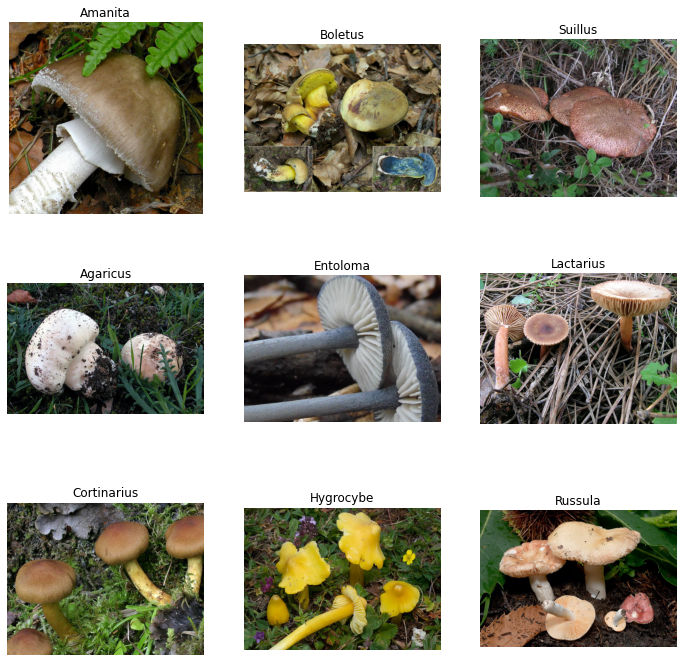

In [12]:
nrows = 3
ncols = 3

pos = 0

for subfolder in os.listdir(data_path):
    
    image_file = os.listdir(os.path.join(data_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(data_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

In [13]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [14]:
IMAGE_SIZE = [224, 224]

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
training_set = train_datagen.flow_from_directory(
'/content/temp/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')
val_set = val_datagen.flow_from_directory('/content/temp/valid',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('/content/temp/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 5033 images belonging to 9 classes.
Found 1005 images belonging to 9 classes.
Found 676 images belonging to 9 classes.


In [17]:
model=tensorflow.keras.applications.resnet_v2.ResNet50V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=9,
    classifier_activation='softmax'
)

In [18]:
#model = tensorflow.keras.applications.xception.Xception(weights='imagenet',include_top=True)

In [19]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [21]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [23]:
history = model.fit(training_set,
                        validation_data=val_set,
                        epochs=100,
                        steps_per_epoch=79,
                        validation_steps=16,
                        verbose=2,
                        callbacks=[reduce_lr, early_stop],
                        use_multiprocessing=True,
                        workers=2)

Epoch 1/100
79/79 - 158s - loss: 1.9673 - accuracy: 0.2982 - val_loss: 5.5270 - val_accuracy: 0.1512 - lr: 0.0010 - 158s/epoch - 2s/step
Epoch 2/100
79/79 - 116s - loss: 1.7143 - accuracy: 0.3912 - val_loss: 3.9923 - val_accuracy: 0.1910 - lr: 0.0010 - 116s/epoch - 1s/step
Epoch 3/100
79/79 - 116s - loss: 1.5772 - accuracy: 0.4502 - val_loss: 2.8705 - val_accuracy: 0.1940 - lr: 0.0010 - 116s/epoch - 1s/step
Epoch 4/100
79/79 - 119s - loss: 1.4853 - accuracy: 0.4800 - val_loss: 2.7524 - val_accuracy: 0.3025 - lr: 0.0010 - 119s/epoch - 2s/step
Epoch 5/100
79/79 - 118s - loss: 1.4063 - accuracy: 0.5116 - val_loss: 2.6064 - val_accuracy: 0.2547 - lr: 0.0010 - 118s/epoch - 1s/step
Epoch 6/100
79/79 - 117s - loss: 1.3535 - accuracy: 0.5206 - val_loss: 2.4684 - val_accuracy: 0.2736 - lr: 0.0010 - 117s/epoch - 1s/step
Epoch 7/100
79/79 - 116s - loss: 1.1142 - accuracy: 0.6126 - val_loss: 1.9205 - val_accuracy: 0.4070 - lr: 1.0000e-04 - 116s/epoch - 1s/step
Epoch 8/100
79/79 - 122s - loss: 1.02

In [24]:
model.save('mcpr.h5')

In [25]:
loss, accuracy = model.evaluate(test_set,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 9s - loss: 1.0885 - accuracy: 0.6317 - 9s/epoch - 815ms/step
Model performance on test images:
Accuracy = 0.63165682554245
Loss = 1.0885014533996582


In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model = load_model("mcpr.h5") #loading the model for testing

In [28]:
img = image.load_img(r"/content/temp/test/Entoloma/032_lPevIofLngY.jpg",target_size= (224,224))#loading of the image
x = image.img_to_array(img)#image to array
x = np.expand_dims(x,axis = 0)#changing the shape
preds=model.predict(x)
pred=np.argmax(preds,axis=1)
index=['Agaricus','Amanita','Boletus','Cortinarius','Entoloma','Hygrocybe','Lactarius','Russula','Suillus']
result=str(index[pred[0]])
result

1/1 [==============================] - 0s 23ms/step


'Boletus'